In [3]:
import pandas as pd
import ta
import os
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
import seaborn as sns
import plotly.express as px
import numpy as np
from scipy import stats
from sklearn.metrics import mean_absolute_error



os.chdir("../")

In [4]:
df = pd.read_parquet('data/bronze/crypto_stock_bronze_btc.parquet')

In [5]:
df.head()

,last_close,last_open,last_max,last_min,volume,date
0,314.890015,318.239990,321.359985,313.540009,12820,2015-01-01
1,315.209991,314.890015,316.399994,313.079987,14729,2015-01-02
2,287.130005,315.209991,315.829987,284.890015,47366,2015-01-03
3,264.720001,287.130005,289.940002,255.869995,88769,2015-01-04
4,274.839996,264.720001,278.320007,262.890015,54993,2015-01-05


#Feature selection

<Axes: xlabel='date'>

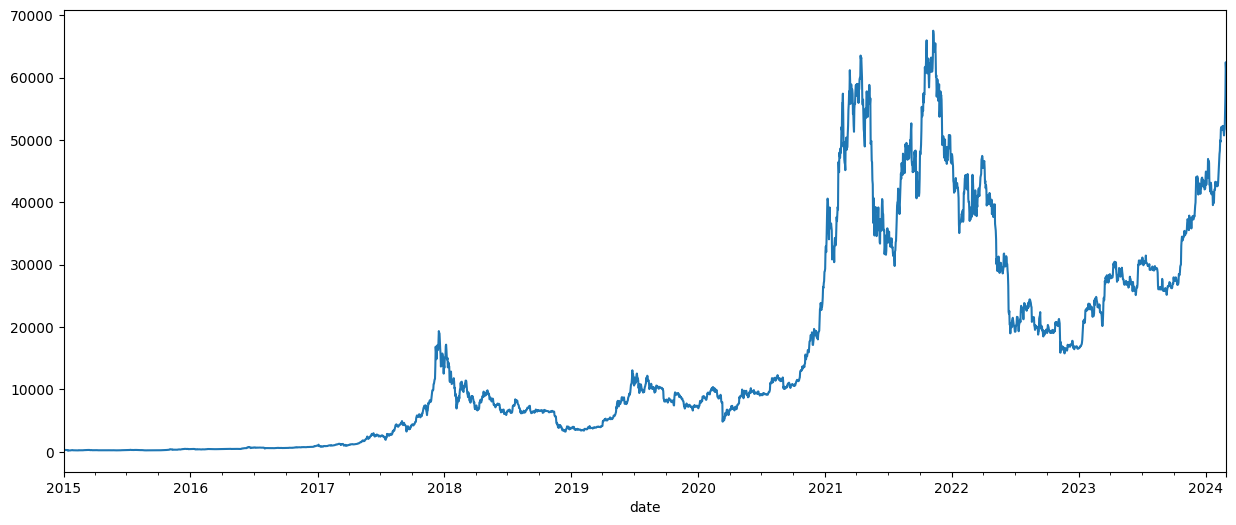

In [6]:
df.set_index("date").last_close.plot(figsize = (15,6))

In [7]:
df.set_index("date", inplace = True,drop=True)

In [8]:
X = df.drop(columns = ["last_close"])
y = df.last_close

In [9]:
pd.DataFrame(y).describe()

,last_close
count,3347.000000
mean,15588.381103
std,16629.893817
min,164.919998
25%,1248.660034
50%,8806.701172
75%,26526.853516
max,67527.851562


In [10]:
y[-500:]

date
2022-10-18    19328.224609
2022-10-19    19123.917969
2022-10-20    19042.865234
2022-10-21    19162.603516
2022-10-22    19204.798828
                  ...     
2024-02-25    51722.722656
2024-02-26    54495.066406
2024-02-27    57056.164062
2024-02-28    62467.597656
2024-02-29    61169.281250
Name: last_close, Length: 500, dtype: float64

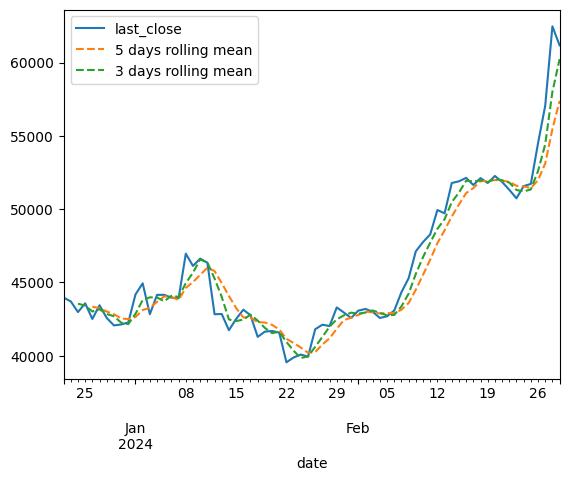

In [11]:
y[-70:].plot()
y[-70:].rolling(window = 5).mean().plot(label = '5 days rolling mean',style= '--')
y[-70:].rolling(window = 3).mean().plot(label = '3 days rolling mean',style='--');    
plt.legend();

I want to predict 4 days ahead.


## Simple Rate of Return

The simple rate of return is a fundamental metric used to assess an investment's performance over a specific period. It is represented as a percentage and signifies the percentage increase or decrease relative to the initial investment.

To compute the simple rate of return, you require the following details:

1. Initial investment value (or initial cost).
2. Final investment value (or current value).
3. Time period for which the return is calculated.

The formula for computing the simple rate of return is:


$$\text{Simple rate of return} = \left( \frac{{\text{Final investment value} - \text{Initial investment value}}}{{\text{Initial investment value}}} \right) \times 100\%
$$

For instance, assume you invested $10,000 in stocks, and after one year, the value increased to $11,500. To determine the simple rate of return, you would apply the formula as follows:


$$\text{Simple rate of return} = \left( \frac{{11,500 - 10,000}}{{10,000}} \right) \times 100\% = \left( \frac{{1,500}}{{10,000}} \right) \times 100\% = 0.15 \times 100\% = 15\%$$

Therefore, the simple rate of return on your investment would be 15%.

It's worth noting that the simple rate of return disregards time and any intermediate cash flows during the investment period. Consequently, it may be more suitable for comparing short-term investment performance or situations devoid of intermediate cash flows.



<Axes: xlabel='date'>

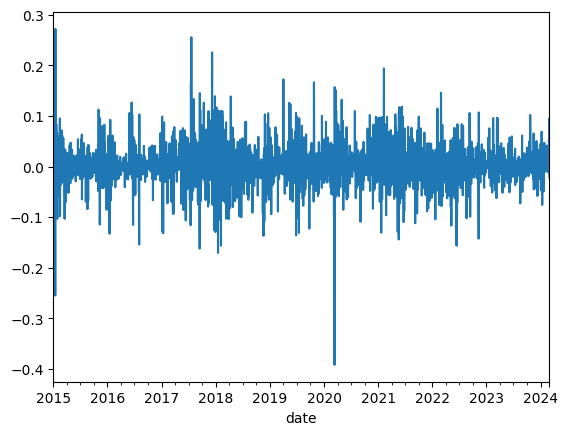

In [12]:
((y / y.shift(1)) - 1).plot()

In [13]:
(((y / y.shift(1)) - 1).mean() * 365) * 100

83.34270110783596

In [14]:
normalize_bitcoin = (y/y.iloc[0])

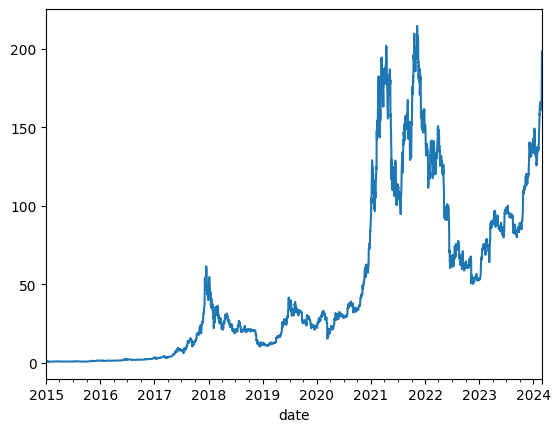

In [15]:
normalize_bitcoin.plot();

In [16]:
figure = px.line(y, title = 'BTC price')
figure.show()

In [17]:
y.describe()

count     3347.000000
mean     15588.381103
std      16629.893817
min        164.919998
25%       1248.660034
50%       8806.701172
75%      26526.853516
max      67527.851562
Name: last_close, dtype: float64

In [18]:
y.groupby(y.index.year).std()

date
2015       58.922578
2016      138.347620
2017     3987.175292
2018     2425.516896
2019     2649.945877
2020     4310.341876
2021     9775.209790
2022    10192.406836
2023     5902.233021
2024     5195.644832
Name: last_close, dtype: float64

<Axes: >

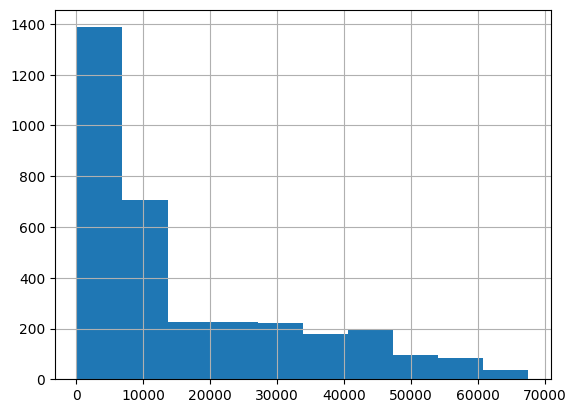

In [19]:
y.hist()

# Monte carlo simulation

In [20]:
y

date
2015-01-01      314.890015
2015-01-02      315.209991
2015-01-03      287.130005
2015-01-04      264.720001
2015-01-05      274.839996
                  ...     
2024-02-25    51722.722656
2024-02-26    54495.066406
2024-02-27    57056.164062
2024-02-28    62467.597656
2024-02-29    61169.281250
Name: last_close, Length: 3347, dtype: float64

In [21]:
normalize_bitcoin

date
2015-01-01      1.000000
2015-01-02      1.001016
2015-01-03      0.911842
2015-01-04      0.840674
2015-01-05      0.872813
                 ...    
2024-02-25    164.256471
2024-02-26    173.060637
2024-02-27    181.193945
2024-02-28    198.379100
2024-02-29    194.256021
Name: last_close, Length: 3347, dtype: float64

In [22]:
df_retorn_tax =  np.log(1 + normalize_bitcoin.pct_change())

In [23]:
df_retorn_tax.dropna(inplace = True)    

In [24]:
#drift
u = df_retorn_tax.mean()
var = df_retorn_tax.var()
drift = u - (0.5 * var)

In [25]:

days_ahead = 35
simulations = 10
std = df_retorn_tax.std()

In [26]:
Z = stats.norm.ppf(np.random.rand(days_ahead, simulations))

In [27]:
Z.shape

(35, 10)

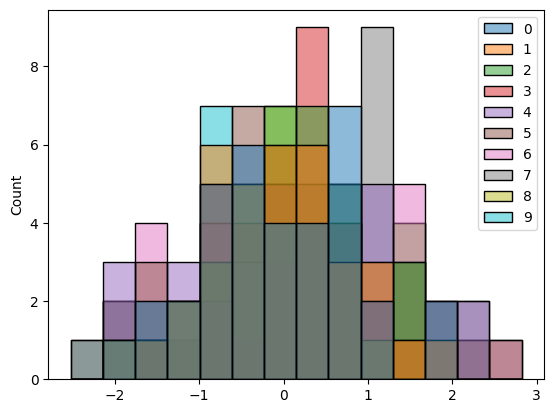

In [28]:
sns.histplot(Z);

In [29]:
diary_return = np.exp(drift + std * Z)

In [30]:
diary_return.shape

(35, 10)

In [31]:
predict = np.zeros_like(diary_return)

In [32]:
predict[0] = y.iloc[-35]

In [33]:
for day in range(1, days_ahead):
  predict[day] = predict[day - 1] * diary_return[day]

In [34]:
figura = px.line(title = 'Previsões do preço das ações - simulações')
for i in range(len(predict.T)):
  figura.add_scatter(y = predict.T[i], name = i)
figura.show()

In [35]:
erros = dict()
for i in range(len(predict.T)):
  simulation = predict.T[i][0:35]
  erros[f"simulation_{i}"] = mean_absolute_error(y[-35:], simulation)

In [36]:
best_value_dict = min(erros, key = erros.get)
worst_value_dict = max(erros, key = erros.get)

In [37]:
best_value = list(erros.keys()).index(best_value_dict)
worst_value_dict = list(erros.keys()).index(worst_value_dict)


In [38]:
figura = px.line(title = 'Predict price BTC - Simulation')
figura.add_scatter(y = y[-35:], name = 'Real Value')
figura.add_scatter(y = predict.T[worst_value_dict], name = 'Worst Simulation')
figura.add_scatter(y = predict.T[best_value], name = 'Best Simulation')

In [39]:
def monte_carlo_simulation(y, days_ahead, simulations):
  df_retorn_tax =  np.log(1 + y.pct_change())
  df_retorn_tax.dropna(inplace = True)    
  u = df_retorn_tax.mean()
  var = df_retorn_tax.var()
  drift = u - (0.5 * var)
  std = df_retorn_tax.std()
  Z = stats.norm.ppf(np.random.rand(days_ahead, simulations))
  diary_return = np.exp(drift + std * Z)
  predict = np.zeros_like(diary_return)
  predict[0] = y.iloc[-days_ahead]
  for day in range(1, days_ahead):
    predict[day] = predict[day - 1] * diary_return[day]
  return predict

In [44]:
a = monte_carlo_simulation(y, 35, 10).copy()